# Test pipeline
1. Create dataset: sequence of preporcessed examples ready to feed to neuralnet 
2. Create dataloader: define how dataset is loaded to neuralnet (batch size, order, computation optimizing ...)
3. Create model : a bunch of matrixes math to transform input tensor to output tensor
4. Training loop:
    + Forward 
    + Calculate loss
    + Backward
    + Monitoring: 
        + Evaluate metrics
        + Logger, back and forth
        + Visualize

# Import necessary packages

In [1]:
import os
import glob
import sys
import random

import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

import numpy as np

from sklearn.model_selection import ShuffleSplit




torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline


sys.path.insert(0, '..')
from src.models.utils import FaceDataset

In [2]:
sys.path

['..',
 '/home/anhduy/face-attributes/notebooks',
 '/home/anhduy/anaconda3/envs/age_gender/lib/python38.zip',
 '/home/anhduy/anaconda3/envs/age_gender/lib/python3.8',
 '/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/lib-dynload',
 '',
 '/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages',
 '/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/IPython/extensions',
 '/home/anhduy/.ipython']

In [3]:
!pip install shapely

# Create a transformer

In [4]:

def resize_img_label(image,label,target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    return image_new,label

def transformer(image, label, params):
    image,label = resize_img_label(image,label,params["target_size"]) 
    image = TF.to_tensor(image)
    return image, label


# Create Data loader

In [5]:
trans_params_train = {
    "target_size" : (112, 112),
}

trans_params_val={
    "target_size" : (112, 112), 
}

path2data = "/home/Data/"

In [6]:
# create data set
train_ds = FaceDataset(path2data + "training_dataset.csv", transformer, trans_params_train)
val_ds = FaceDataset(path2data + "valid_dataset.csv", transformer, trans_params_val)

print(len(train_ds))
print(len(val_ds))

201432
3736


In [7]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

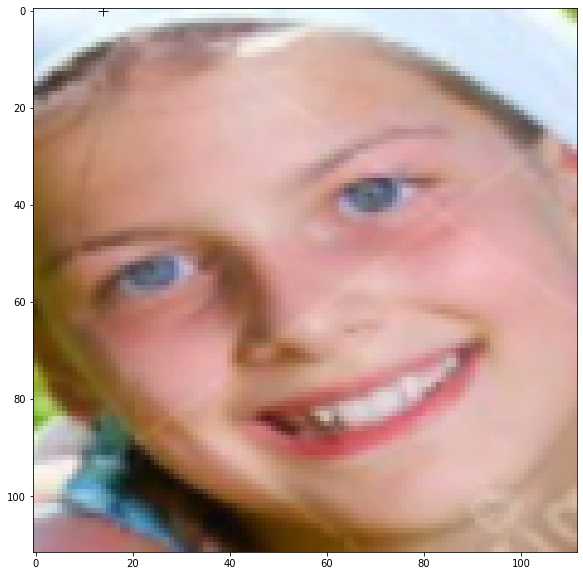

In [8]:
plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

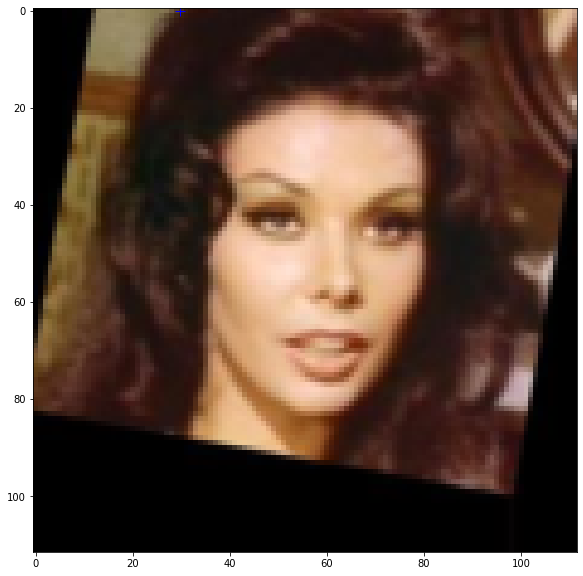

In [9]:
plt.figure(figsize=(10,10))
count  = 0
for img,label in val_ds:
    show(img,label)
    break

In [10]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 256, shuffle=False)

In [11]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([32, 3, 112, 112]) torch.float32
torch.Size([32, 2])


In [12]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([256, 2])



# Create Model

In [13]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [18]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 
    self.dropout_rate=params["drop_rate"] 
    self.num_fc1 = params["num_fc1"]

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16*init_f, self.num_fc1)
    self.fc2 = nn.Linear(self.num_fc1, num_outputs)
    self.age_head = nn.Linear(num_outputs, 1)
    self.gender_head = nn.Linear(num_outputs, 1)

In [19]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x = F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = F.relu(self.fc1(x))
    
    x = F.dropout(x, self.dropout_rate, training = self.training)
    
    x = F.relu(self.fc2(x))
    
    gender = F.sigmoid(self.gender_head(x))
    age = self.age_head(x)
    
    return age, gender


In [21]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,112,112),
        "initial_filters": 64, 
        "num_outputs": 1024,
        "drop_rate" : 0.2,
        "num_fc1" : 512
        }

model = Net(params_model)

# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   model = nn.DataParallel(model)

# device = torch.device("cuda")
# model = model.to(device)

In [24]:
from torchsummary import summary
summary(model, input_size=(3, 112, 112),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
            Conv2d-2          [-1, 128, 28, 28]          77,312
            Conv2d-3          [-1, 256, 14, 14]         449,536
            Conv2d-4            [-1, 512, 7, 7]       2,078,720
            Conv2d-5           [-1, 1024, 3, 3]       8,876,032
            Linear-6                  [-1, 512]         524,800
            Linear-7                 [-1, 1024]         525,312
            Linear-8                    [-1, 1]           1,025
            Linear-9                    [-1, 1]           1,025
Total params: 12,535,554
Trainable params: 12,535,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 2.95
Params size (MB): 47.82
Estimated Total Size (MB): 50.92
-----------------------------------

/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Create optimizer

In [98]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)

# Create custom Performance

In [93]:

from src.models import experiment
from src.models.experiment import Performance

class CustomPerformance(Performance):
    def __init__(self):
        Performance.__init__(self)
        self.gender_loss_func = nn.BCELoss(reduction="sum")
        self.age_loss_func = nn.MSELoss(reduction="sum")
        
    def loss_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        loss_age = self.age_loss_func(age, age_targets)
        
        loss_gender = self.gender_loss_func(gender, gender_targets)
        
        loss = loss_age + loss_gender*10
        
        return loss

    def metrics_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        gender = gender > 0.5
        acc_gender = (gender == gender_targets).sum()
        
        mae_age = torch.abs(age - age_targets).sum()
            
        return torch.tensor([acc_gender, mae_age])


# Training

In [96]:
root_logdir = '../models'

def get_run_logdir():
    import time
    run_id = time.strftime("exp_%Y_%m_%d-%H_%M_%S")
    if not os.path.isdir(os.path.join(root_logdir, run_id)):
        os.makedirs(os.path.join(root_logdir, run_id))
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [102]:
performance = CustomPerformance()
num_epochs = 20

path2models= os.path.join(run_logdir, 'best_checkpoints.bin')
params = experiment.Prams(num_epochs=num_epochs, path2weights=path2models, device=device,optimizer=opt, lr_scheduler=lr_scheduler, sanity_check=False)

pipeline = experiment.Pipeline(model, train_dl, val_dl, performance, params)
model, performance = pipeline.train_val()

Epoch 0/19, current lr=0.001
Copied best model weights!
train loss: 104.978386
val loss: 266.418091
----------
Epoch 1/19, current lr=0.001
train loss: 69.084404
val loss: 283.148499
----------
Epoch 2/19, current lr=0.001
train loss: 57.550091
val loss: 316.531433
----------
Epoch 3/19, current lr=0.001
train loss: 50.609966
val loss: 290.719788
----------
Epoch 4/19, current lr=0.001
train loss: 46.058506
val loss: 288.287628
----------
Epoch 5/19, current lr=0.001
train loss: 42.951031
val loss: 282.906647
----------
Epoch 6/19, current lr=0.001
train loss: 40.923298
val loss: 309.457825
----------
Epoch 7/19, current lr=0.001
train loss: 38.773029
val loss: 306.292328
----------
Epoch 8/19, current lr=0.001
train loss: 37.000538
val loss: 350.869751
----------
Epoch 9/19, current lr=0.001
train loss: 35.225487
val loss: 306.756348
----------
Epoch 10/19, current lr=0.001
train loss: 34.015682
val loss: 315.815430
----------
Epoch 11/19, current lr=0.001
Epoch    12: reducing learni

In [69]:
!pwd

/home/anhduy/face-attributes/notebooks


In [103]:
loss_hist, metrics_history = performance.loss_history, performance.metrics_history
train_hist = torch.stack(metrics_history["train"])
val_hist = torch.stack(metrics_history["val"])

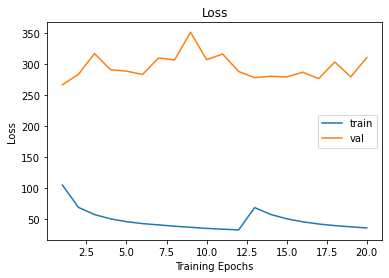

In [104]:
# Train-Validation Progress

# plot loss progress
plt.title("Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

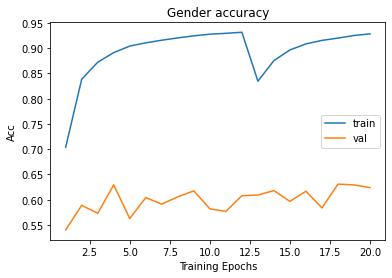

In [105]:
# plot accuracy progress
plt.title("Gender accuracy")
plt.plot(range(1,num_epochs+1),train_hist[:,0], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,0],label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

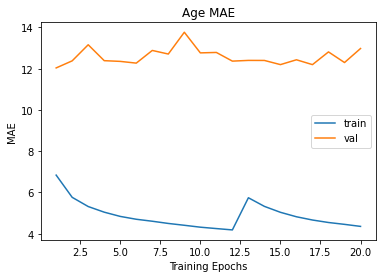

In [106]:
# plot accuracy progress
plt.title("Age MAE")
plt.plot(range(1,num_epochs+1),train_hist[:,1], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,1],label="val")
plt.ylabel("MAE")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Testing

In [107]:
test_ds = FaceDataset(path2data + "testing_dataset.csv", transformer, trans_params_val)

In [108]:
test_dl = DataLoader(test_ds, batch_size = 256, shuffle=False)

In [109]:
loss_test, metrics_test = pipeline.test(test_dl)

/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [110]:
# Gender Accuracy
print(max(train_hist[:,0]))
print(max(val_hist[:,0]))
print(metrics_test[0])

tensor(0.9316)
tensor(0.6309)
tensor(0.5478)


In [111]:
# Age MAE
print(min(train_hist[:,1]))
print(min(val_hist[:,1]))
print(metrics_test[1])

tensor(4.1849)
tensor(12.0360)
tensor(11.6461)


In [112]:
# Loss
print(min(loss_hist["train"]))
print(min(loss_hist["val"]))
print(loss_test)

tensor(32.8079, device='cuda:0', grad_fn=<DivBackward0>)
tensor(266.4181, device='cuda:0')
tensor(251.1151, device='cuda:0')
